# Supplementary Material for Chapter "Stable Diffusion"

This notebook is a supplement to the chapter "Diffusion Models". This includes examples as well as the exercise solutions.

## Exercises

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the solutions before taking a stab at the problem. Scroll down for th answers

### Project: Build an interactive ML demo with Gradio

Let's first run the example code to see how it works.

In [ ]:
import gradio as gr


def greet(name):
    return "Hello " + name


demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Let's now do a demo for Stable Diffusion. We will first load the pipeline and then create a function that receives the input and returns the output.

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
def generate(prompt):
    return pipe(prompt, num_samples=1).images[0]


demo = gr.Interface(generate, inputs="text", outputs="image")
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/50 [00:00<?, ?it/s]

You can go creative now! Let's add some new features

In [ ]:
def generate(prompt, negative_prompt, num_steps):
    return pipe(
        prompt,
        num_samples=1,
        negative_prompt=negative_prompt,
        num_inference_steps=num_steps,
    ).images[0]


demo = gr.Interface(
    generate,
    inputs=[
        gr.Textbox(
            label="Prompt",
            lines=2,
        ),
        gr.Textbox(
            label="Negative prompt",
            lines=2,
        ),
        gr.Slider(
            minimum=30, maximum=100, step=5, value=50, label="Number of steps"
        ),
    ],
    outputs="image",
    title="Stable Diffusion demo",
)
demo.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Exercises

**1. How does the training process of a class-conditioned diffusion model differ from a non-conditioned model, particularly in terms of the input data and the loss function used?**

The process is almost the same, except that the model is also passed the labels for additional conditioning. The loss function is not affected by this as it's primarily concerned with comparing the generated data with the original noise, regardless of whether conditioning labels are used or not.

**2. How does the timestep embedding influence the quality and evolution of the images during the diffusion process?**

The models from the previous chapter can be seen as a special case of conditioned diffusion model in which the model is conditioned on the timestep. The timestep embedding provides temporal information about the current stage of the diffusion process, which allows the model to generate images that are more coherent and realistic as the diffusion process progresses. As the timestep informs about the level of diffusion that has occurred so far, the model can use this information to generate refined images.

**3. Explain the difference between latent diffusion and normal diffusion. What are the trade-offs of using latent diffusion?**

Latent diffusion and normal diffusion differ in the space where they operate. Normal diffusion processes directly manipulate pixel values in images, which can be computationally intensive and less scalable, especially for large images. In contrast, latent diffusion operates in a lower-dimensional latent space, often facilitated by a Variational Autoencoder (VAE), making it more scalable and memory-efficient.

The advantages of latent diffusion include reduced memory usage and faster generation times due to its operation in a smaller space. However, there are trade-offs. Latent diffusion models may sacrifice some interpretability compared to normal diffusion models since they operate in a latent space. Additionally, incorporating the VAE component can introduce complexity and potentially make training more challenging.

**4. How is the text prompt incorporated into the model?**

As seen in Chapter 3, CLIP can manage both images and text. To handle text, it uses a text encoder which is a decoder-only transformer as the ones in Chapter 2. This text encoder is used to generate the text prompt embeddings, which are then used to condition the diffusion model by being passed as an additional input, allowing the model to generate images that align with the given text prompt.

**5. What is the difference between model-based and classifier-free guidance? What is the benefit of classifier-free guidance?**

* **Classifier-free guidance:** In this approach, the guidance is provided directly through the diffusion model's conditioning inputs, without relying on a separate classifier model. To achieve this, we combine the generations of conditional and unconditional diffusion models. CFG allows to ensure the text prompt is strongly incorporatd in the generation process. It also removes the need of a separate model.
* **Model-based guidance** refers to the approach of using a separate model, such as a classifier, to guide the generation process. The classifier model is used to calculate the loss, which is incorporated into the inference process.

**6. What is the effect of using a negative prompt? Experiment with it using `pipe(..., negative_prompt="")`. How are you able to guide the image using Stable Diffusion?**

Using a negative prompt allows to guide the image generation process away from a certain attribute or style. For example, if you are generating images of cats and you want to avoid generating black cats, you can use a negative prompt to guide the model away from generating black cats.

**7. Let's say you want to remove white hats from any generated image. How can you use negative prompts for this? Try implementing this using the high-level pipeline and then adapting the end-to-end inference example (hint: it only requires modifying the random part of the classifier-free conditioning).**

Let's first load the model

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


And let's kick off with an initial image

  0%|          | 0/50 [00:00<?, ?it/s]

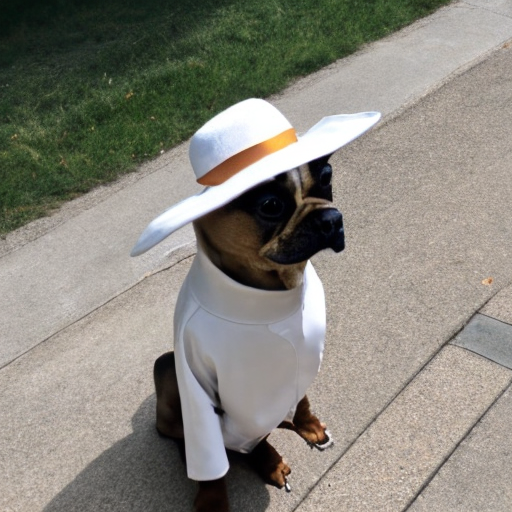

In [ ]:
pipe("A dog wearing a white hat").images[0]

Now let's use a negative prompt to remove the white hat

  0%|          | 0/50 [00:00<?, ?it/s]

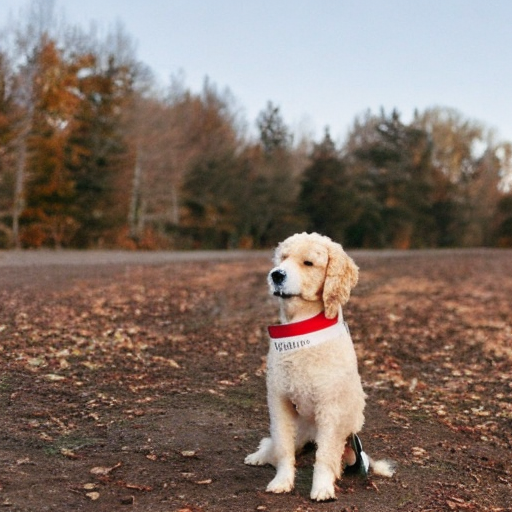

In [ ]:
pipe("A dog wearing a white hat", negative_prompt="a white hat").images[0]

Let's now write the full inference code

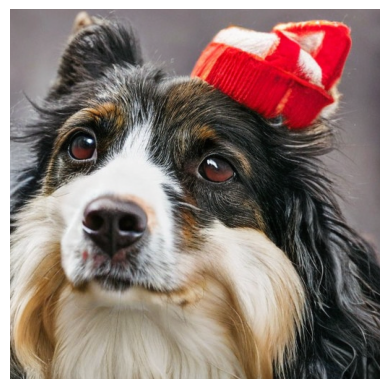

In [ ]:
from genaibook.core import show_image

# Same as before
guidance_scale = 7.5
text_input = pipe.tokenizer(
    "A dog with a white hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# This was the only change! Rather than unconditional input, we're using a negative prompt
neg_input = pipe.tokenizer(
    "White hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    return_tensors="pt",
)

with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    neg_prompt_embeddings = pipe.text_encoder(neg_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([neg_prompt_embeddings, text_embeddings])

pipe.scheduler.set_timesteps(30)
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, 64, 64),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

for i, t in enumerate(pipe.scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

latents = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float());

**8. What happens in SDXL if you use (256, 256) instead of (1024, 1024) as the "original size" conditioning signal? What happens if you use crop coordinates other than (0, 0)? Can you explain why?**

* If you use crop coordinates of (0, 0), the subject is more likely to be centered in the image. If you use different crop coordinates, the subject will be placed in different positions in the image.
* If you use (256, 256) instead of (1024, 1024) as the "original size" conditioning signal, the model will still generate output images at the default resolution of (1024, 1024). However, they are likely to lack detail and look blurred or upscaled. This is because small images in the training dataset were upscaled during training, and their original size was used as a conditioning signal. Therefore, the model learned what a small but upscaled image looks like. When using the same conditioning signal during inference, the model is likely to produce something that resembles a small upscaled image.

Challenges

**9. Blue Guidance. Let's say we want to bias generated images to a specific color, such as blue. How can we do that? The first step is to define a conditioning function we'd like to minimize, which, in this case, will be a color loss.**

In [ ]:
def color_loss(images, target_color=(0.1, 0.5, 0.9)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color."""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

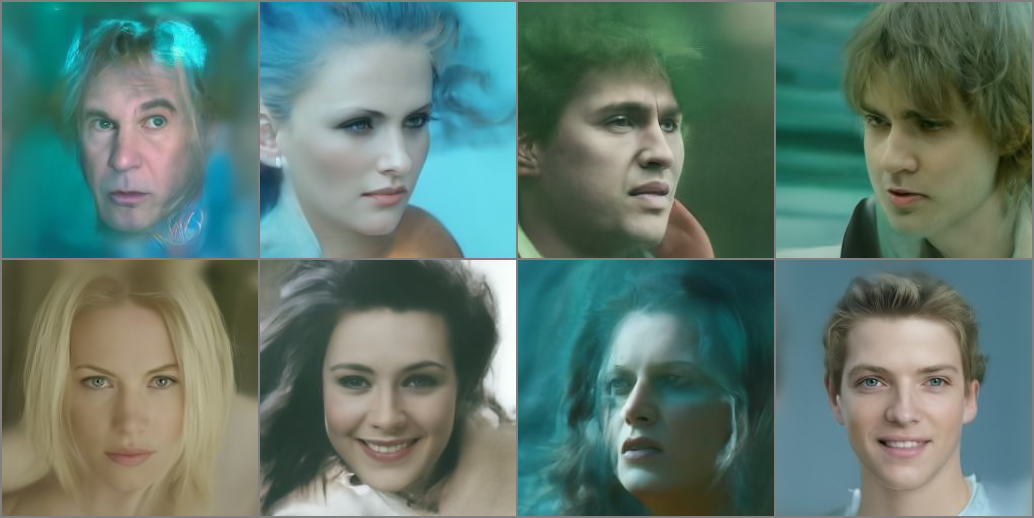

In [ ]:
import numpy as np
import torch
import torchvision
from diffusers import DDPMPipeline
from PIL import Image

# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)
pipe.scheduler.set_timesteps(num_inference_steps=30)
guidance_loss_scale = 60  # Try changing this to 5 or 100

# Input setup
x = torch.randn(8, 3, 256, 256).to(device)

# Main loop
for i, t in enumerate(pipe.scheduler.timesteps):
    with torch.no_grad():
        noise_pred = pipe.unet(x, t)["sample"]

    # Set x.requires_grad to True
    x = x.requires_grad_()

    # Get the predicted x0
    scheduler_output = pipe.scheduler.step(
        noise_pred, t, x
    ).pred_original_sample

    # Calculate loss and get gradient
    loss = color_loss(scheduler_output) * guidance_loss_scale
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = pipe.scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))